<a href="https://colab.research.google.com/github/jehee-lee/Aerospace_capstone_design/blob/main/%EC%8B%A4%EC%8A%B5_5)_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5%EC%9C%BC%EB%A1%9C_%EB%AA%A8%EB%8D%B8_%ED%95%99%EC%8A%B5(target_%3D_displacement)_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

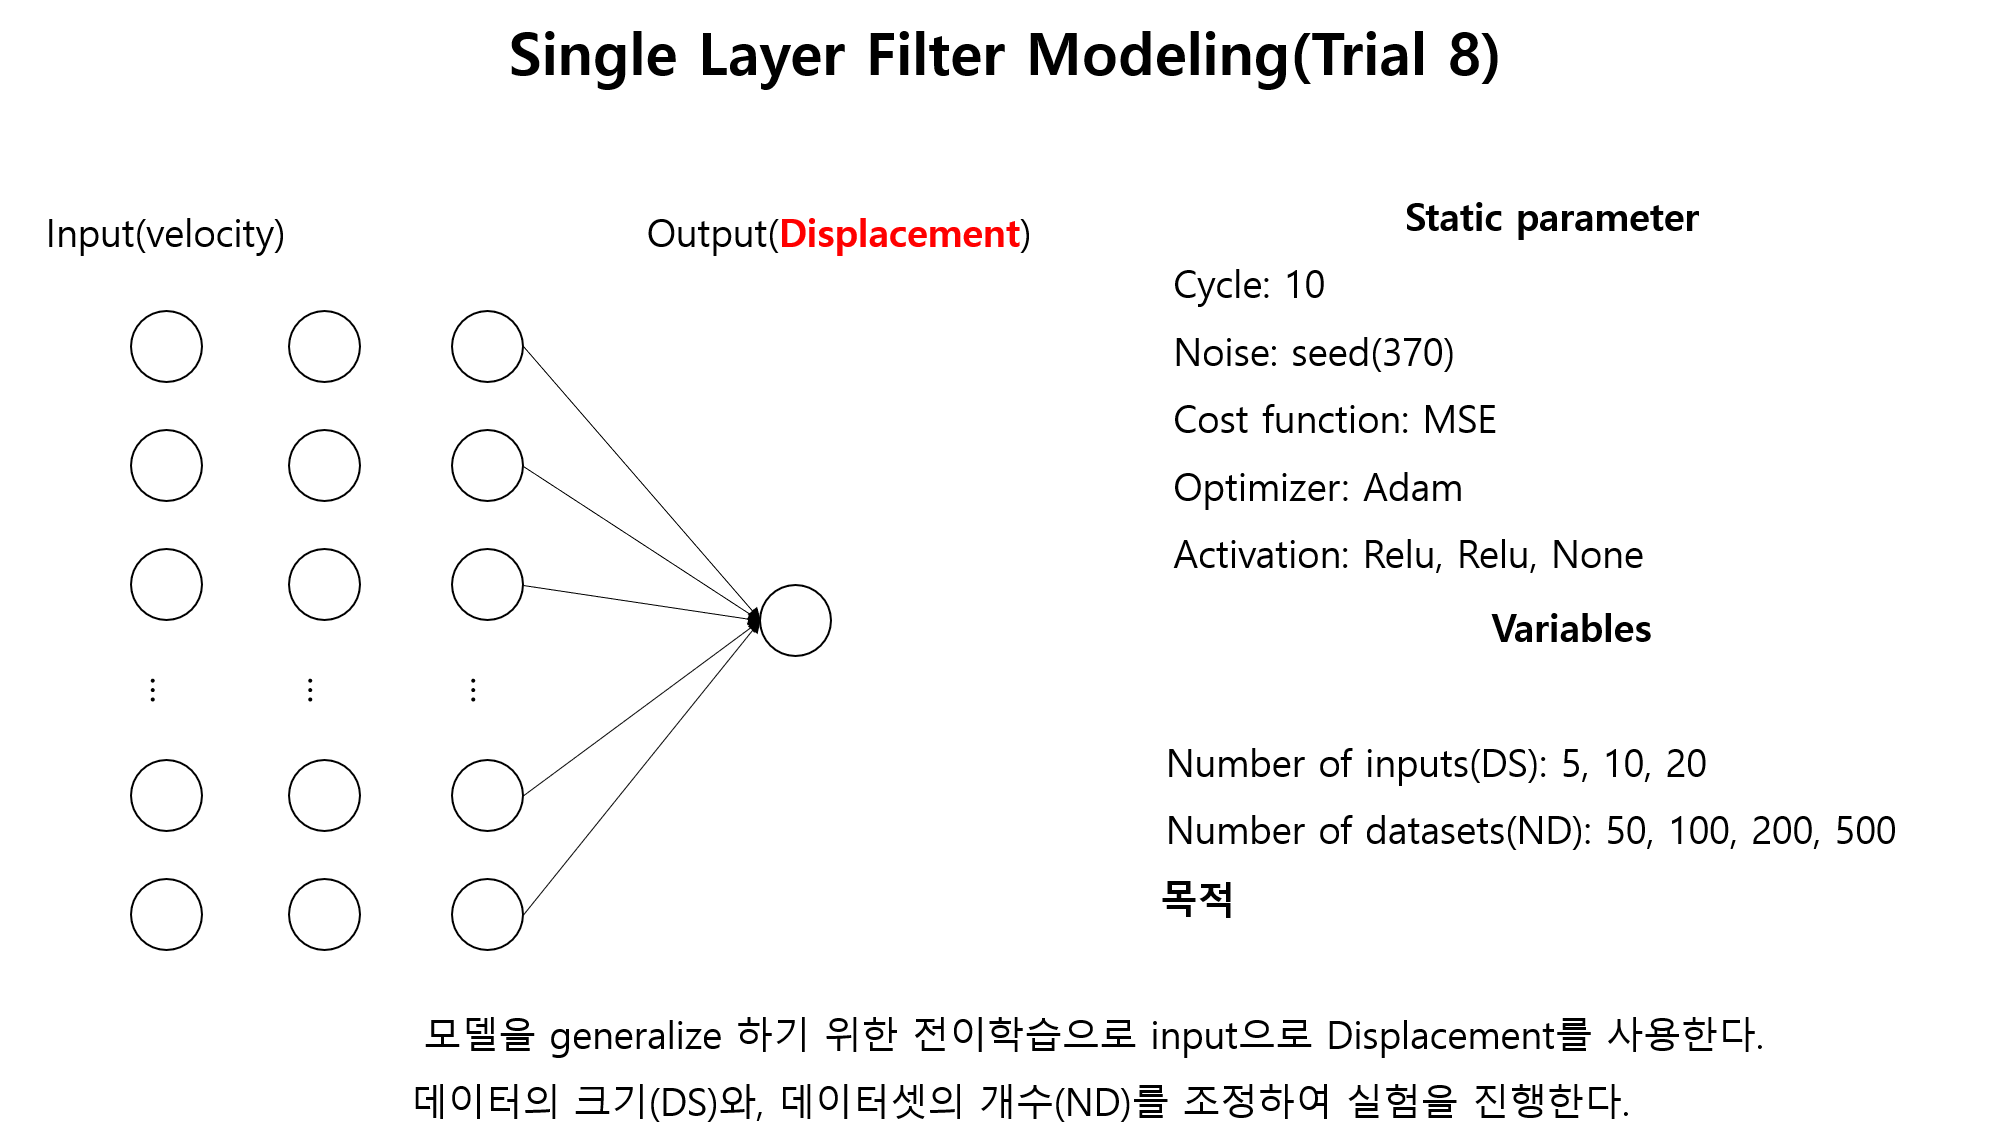

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

A = np.zeros((2,2))
B = np.zeros((2,1))
C = np.zeros((1,2))

#실험 조건, 데이터 사이즈 설정

N = 1000 #number of timesteps

x = np.zeros((2,N+1))
x[:,0]=[0,0]
y = np.zeros((1,N))
dx = np.zeros((1,N))

T=50 #time will vary from 0 to T with step delt
ts = np.linspace(0, T, N+1)
del_t = T/N # delta_t = 0.05 = 50 / 1000
gamma = 0.05 #damping

#정규분포 노이즈 생성
np.random.seed(370)
w = np.random.randn(1,N)
n = np.random.randn(1,N)

# X행렬 구성성분
A[0,0] = 1
A[0,1] = (1-gamma*del_t/2)*del_t
A[1,1] = 1 - gamma*del_t

B[0,0] = del_t**2/2
B[1,0] = del_t

C[0,0] = 1

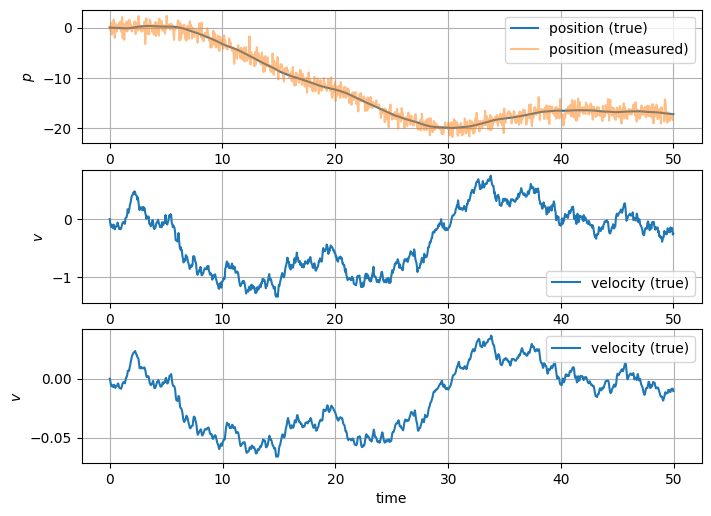

In [ ]:
for t in range(N):
    y[:,t] = C.dot(x[:,t]) + n[:,t]
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])


for t in range(N-1):
    #displacement 추가 
    #현재 변위 = 현재 위치 - 방금 전 위치
    dx[:,t+1] = x[0,t+1] - x[0,t]
    

x_true = x.copy()

plt.figure(figsize=(8,6), dpi=100)
plt.subplot(3,1,1)
plt.plot(ts,x[0,:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[:-1],y[0,:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()
plt.subplot(3,1,2)
plt.plot(ts,x[1,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
#displacement는 velocity와 모양이 같다. (속도에 증분을 곱한 것 이므로)
plt.subplot(3,1,3)
plt.plot(ts[:-1],dx[0,:], label='velocity (true)')
plt.xlabel('time')
plt.ylabel(r'$v$')
plt.legend()
plt.grid()
plt.show()

In [ ]:
pos_t = np.zeros((1,1000))
temp_pos_t = np.zeros((1,1000))


for i in range(N-1):
  temp_pos_t[0,i+1]=temp_pos_t[0,i]+dx[0,i]
  pos_t[0,i+1]=temp_pos_t[0,i+1]

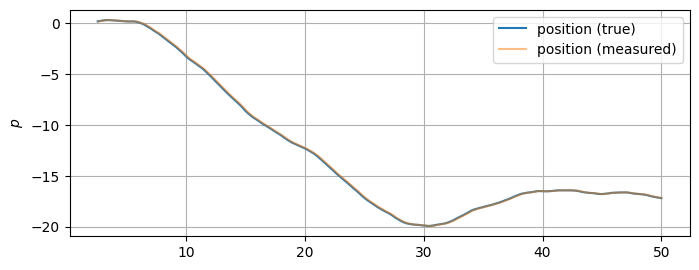

In [ ]:
DS =  50

plt.figure(figsize=(8,3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],pos_t[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()

====================시작===================
(50, 5) (50,)

====================모델 생성===================
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.21707125008106232]
              2 번째 cycle
loss = [0.1646261215209961]
              3 번째 cycle
loss = [0.12648899853229523]
              4 번째 cycle
loss = [0.09889130294322968]
              5 번째 cycle
loss 

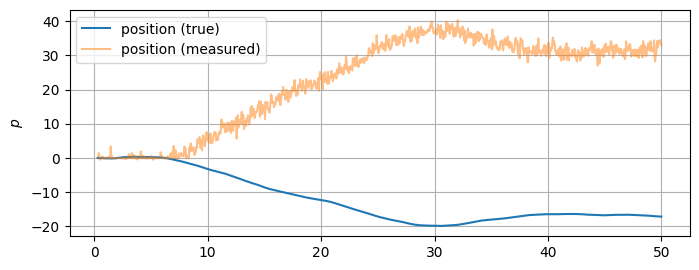

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



DS, ND = 5, 100

====================시작===================
(100, 5) (100,)

====================모델 생성===================
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 3         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.002456747693940997]
              2 번째 cycle
loss = [0.00521098542958498]
              3 번째 cycle
loss = [0.006039780098944902]
              4 번째 cycle
loss = [0.005422431975603104]
              5 번째 cy

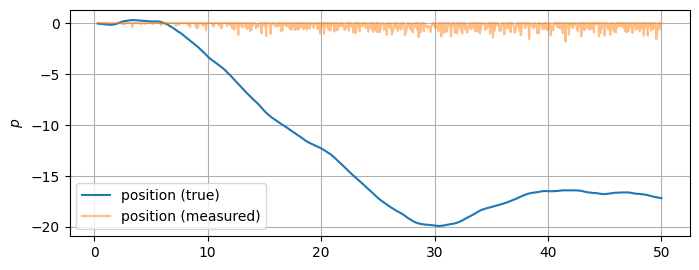

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 100
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



DS, ND = 5, 200

====================시작===================
(200, 5) (200,)

====================모델 생성===================
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 3         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.00013958182535134256]
              2 번째 cycle
loss = [0.0012003050651401281]

====================예측값 갱신===================
0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0

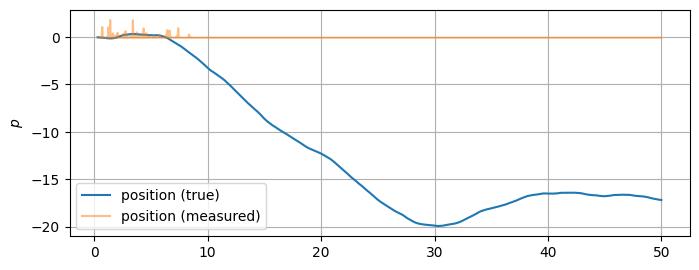

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 200
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 2
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 5, 500

====================시작===================
(500, 5) (500,)

====================모델 생성===================
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 3         
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.0003246504638809711]
              2 번째 cycle
loss = [2.0861003577010706e-05]

====================예측값 갱신===================
0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.0

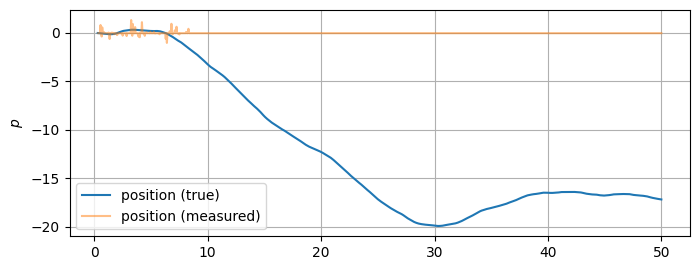

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 5, 500
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 2
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 10, 50

====================시작===================
(50, 10) (50,)

====================모델 생성===================
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.5587435960769653]
              2 번째 cycle
loss = [0.22177262604236603]
              3 번째 cycle
loss = [0.10588569939136505]
              4 번째 cycle
loss = [0.0565892793238163]
              5 번째 cycle
l

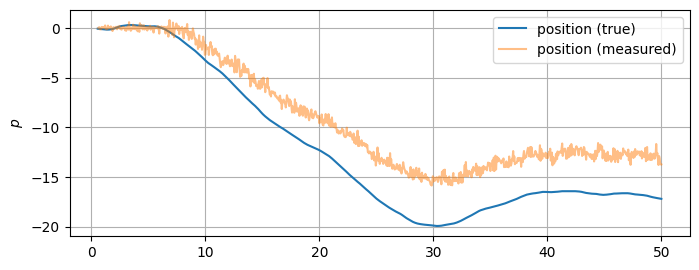

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10 , 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



경향성을 잘 따라감

해당 코드 반복

====================시작===================
(50, 10) (50,)

====================모델 생성===================
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_46 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.02900480292737484]
              2 번째 cycle
loss = [0.017731603235006332]
              3 번째 cycle
loss = [0.011505858972668648]
              4 번째 cycle
loss = [0.007777358405292034]
              5 번째 c

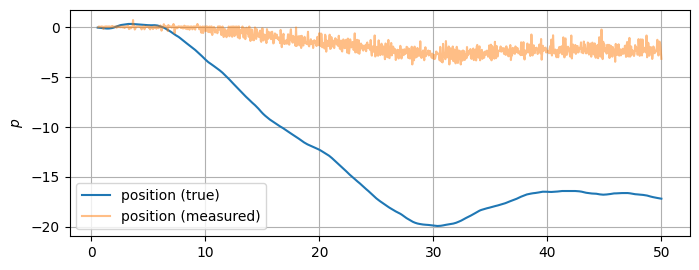

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10 , 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



재현성은 없는듯

ND, DS = 10, 100

====================시작===================
(100, 10) (100,)

====================모델 생성===================
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_52 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.010931776836514473]
              2 번째 cycle
loss = [0.0051100230775773525]

====================예측값 갱신===================
0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60

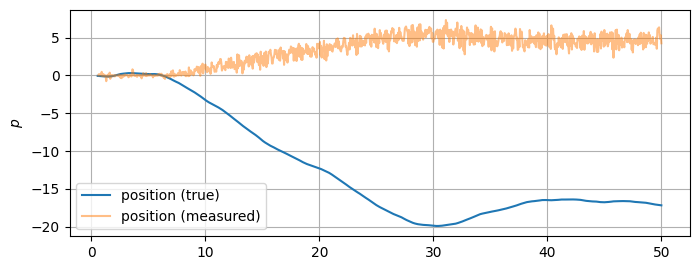

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10 , 100
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 2
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 10, 200

====================시작===================
(200, 10) (200,)

====================모델 생성===================
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.002265745308250189]
              2 번째 cycle
loss = [0.0005427663563750684]

====================예측값 갱신===================
0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.

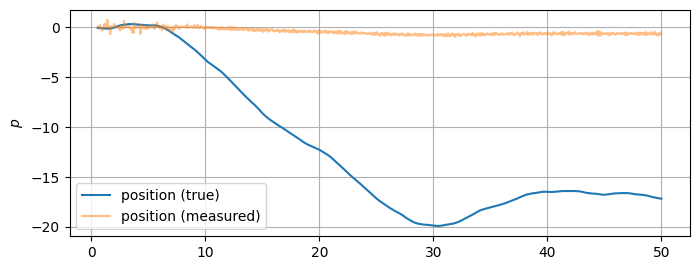

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10 , 200
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 2
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 10, 500

====================시작===================
(500, 10) (500,)

====================모델 생성===================
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.028554165735840797]
              2 번째 cycle
loss = [0.014259988442063332]

====================예측값 갱신===================
0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent
60.

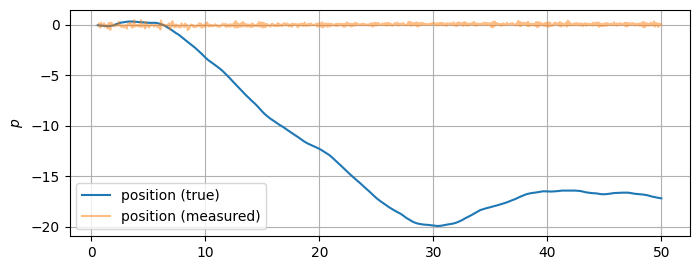

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 10 , 500
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 2
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 20, 50

====================시작===================
(50, 20) (50,)

====================모델 생성===================
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_55 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 11        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [5.3158416748046875]
              2 번째 cycle
loss = [2.6337027549743652]
              3 번째 cycle
loss = [1.3057795763015747]
              4 번째 cycle
loss = [0.628143846988678]
              5 번째 cycle
los

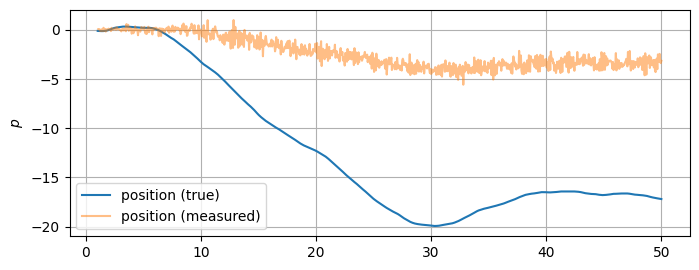

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 20, 50
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 20, 100

====================시작===================
(100, 20) (100,)

====================모델 생성===================
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_58 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 11        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.09230083972215652]
              2 번째 cycle
loss = [0.05069408193230629]
              3 번째 cycle
loss = [0.030969442799687386]
              4 번째 cycle
loss = [0.01973985880613327]
              5 번째 c

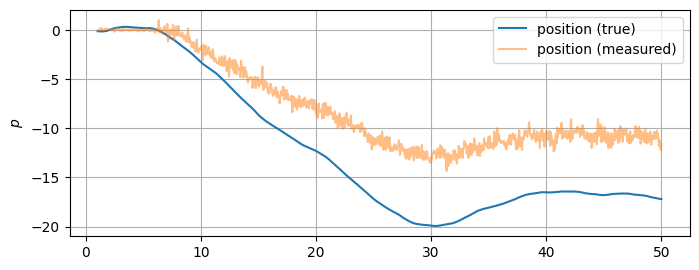

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 20, 100
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



결과가 양호함, 재현

====================시작===================
(100, 20) (100,)

====================모델 생성===================
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_61 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 11        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.0022676882799714804]
              2 번째 cycle
loss = [0.002240676898509264]
              3 번째 cycle
loss = [0.002094482071697712]
              4 번째 cycle
loss = [0.002518103690817952]
              5 

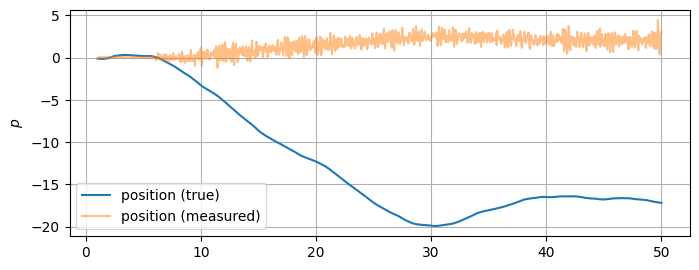

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 20, 100
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 10
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



해당 코드도 재현성은 없는듯

ND, DS = 20, 200

====================시작===================
(100, 20) (100,)

====================모델 생성===================
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_64 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 11        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [0.015695737674832344]
              2 번째 cycle
loss = [0.015453952364623547]
              3 번째 cycle
loss = [0.012024751864373684]
              4 번째 cycle
loss = [0.016605744138360023]
              5 번

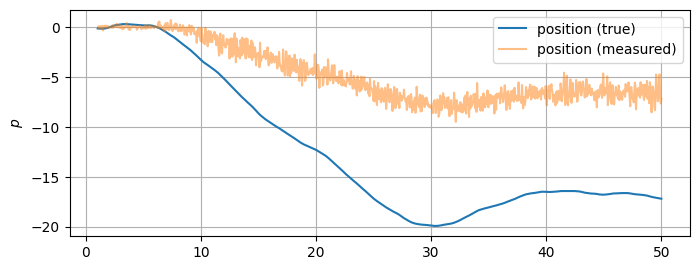

In [ ]:
#데이터 입력
print("====================시작===================")
DS ,ND = 20, 100
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 5
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



ND, DS = 20, 500

====================시작===================
(500, 20) (500,)

====================모델 생성===================
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_67 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 11        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________

====================학습===================
              1 번째 cycle
loss = [5.4428077419288456e-05]
              2 번째 cycle
loss = [4.039988539261685e-07]

====================예측값 갱신===================
0.0 percent
10.0 percent
20.0 percent
30.0 percent
40.0 percent
50.0 percent


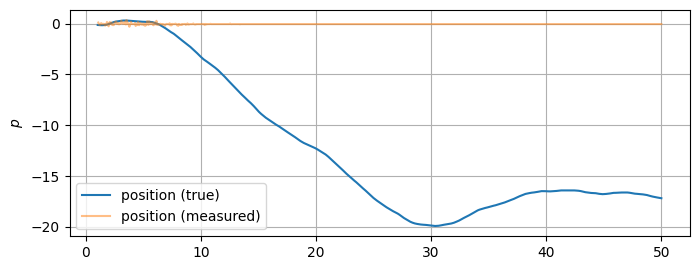

In [30]:
#데이터 입력
print("====================시작===================")
DS ,ND = 20, 500
train_input = np.zeros((1,DS))
train_input = y[0,:DS].copy()
train_input = np.reshape(train_input, [1,DS])
additional_train_input, train_target = None, None



for i in range(ND-1):
  additional_train_input = y[0,i+1:DS+i+1].copy()
  additional_train_input = np.reshape(additional_train_input, (1, DS))
  train_input=np.append(train_input, additional_train_input, axis = 0)
  
train_target = dx[0,1+DS:DS+ND+1].copy()

print(train_input.shape, train_target.shape)

hist = None


#모델 생성
print("")
print("====================모델 생성===================")
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(DS, input_dim=DS, activation='relu'),
  tf.keras.layers.Dense(DS/2, activation='relu'),
  tf.keras.layers.Dense(1)
  ])
model.compile(optimizer = "adam",loss = 'mse',metrics=['mae','mse'])
model.summary()  
      
#학습
input = np.zeros((1,DS))          
output = np.zeros((1,1,DS))  

print("")
print("====================학습===================")
cycle = 2
for t in range(cycle):
  print("             ", t+1, "번째 cycle")
  for i in range(ND):
    input = np.reshape(train_input[i,:], [1,DS])
    target = np.reshape(train_target[i],[1,1])

    hist = model.fit(input, target,epochs = 1, verbose = 0) 
    if i==ND-1:
      print("loss =", hist.history['loss'])

pred_input = None
      
#입력
print("")
print("====================예측값 갱신===================")
for i in range(1000-DS):
  pred_input = y[:,i:DS+i].copy()       
  output=np.append(output,model.predict(pred_input))       
  if i%100==0:
    print("%.1f percent" %(i/10))


#위치 출력
print("")
print("====================위치 출력===================")
output = np.reshape(output,(1,1000))        
pos = np.zeros((1,1000))
temp_pos = np.zeros((1,1000))


for i in range(N-1):
  temp_pos[0,i+1]=temp_pos[0,i]+output[0,i]        
  pos[0,i+1]=temp_pos[0,i+1]
  

output = np.reshape(output,(1,1000))

plt.figure(figsize=(8, 3), dpi=100)
plt.plot(ts[DS+1:],x[0,DS+1:], label='position (true)')
#measured 값은 y값으로 x+noise값이다.
plt.plot(ts[DS+2:],output[0,DS+1:], alpha=0.5, label='position (measured)')
plt.ylabel(r'$p$')
plt.legend()
plt.grid()



500은 과적합이 발생하는듯